In [55]:
import sys
import inspect
import os
import numpy as np
import pandas as pd
import math
import bisect
import matplotlib.pyplot as plt
import seaborn as sb
import ast
import warnings
import itertools
from scipy import stats as st

In [62]:
# Get participant ids
participant_data = pd.read_csv("./data/participant_data.csv")
p_ids = list(participant_data["id"])
p_ids.sort()

# Read in data
main_trials = [pd.read_csv(f"./data/{p_id}/main/trials.csv") for p_id in p_ids]
params = [pd.read_csv(f"./data/{p_id}/params.csv") for p_id in p_ids]
begin_trials = [pd.read_csv(f"./data/{p_id}/begin/trials.csv") for p_id in p_ids]
end_trials = [pd.read_csv(f"./data/{p_id}/end/trials.csv") for p_id in p_ids]
train1_trials = [pd.read_csv(f"./data/{p_id}/train1/trials.csv") for p_id in p_ids]
train2_trials = [pd.read_csv(f"./data/{p_id}/train2/trials.csv") for p_id in p_ids]

In [63]:
# Read last poss
for p_id, trials in zip(p_ids, main_trials):
    last_poss = np.array([np.load(f"./data/{p_id}/main/b{t['block_nr']}_t{t['trial_nr']}_fm.npy", allow_pickle=True)[:,-1] for _, t in trials.iterrows()])
    trials['last_x_real'] = [x[0] for x in np.array(last_poss[:,0])]
    trials['last_x_v'] = [x[0] for x in np.array(last_poss[:,2])]
    trials['last_y_real'] = [x[1] for x in np.array(last_poss[:,0])]
    trials['last_y_v'] = [x[1] for x in np.array(last_poss[:,2])]

In [64]:
# Filter data
main_trials = [trials[trials['time_score'] == 1000] for trials in main_trials]  # Only trials with good timing
train1_trials = [trials[trials['time_score'] == 1000] for trials in train1_trials]  # Only trials with good timing
train2_trials = [trials[trials['time_score'] == 1000] for trials in train2_trials]  # Only trials with good timing

In [65]:
# Combine all data into one frame
for p_id, m, b, e, t1, t2 in zip(p_ids, main_trials, begin_trials, end_trials, train1_trials, train2_trials):
    m['p_id'] = p_id
    b['p_id'] = p_id
    e['p_id'] = p_id
    t1['p_id'] = p_id
    t2['p_id'] = p_id
    
    t2['trial_nr'] = [i for i in range(t2.shape[0])]

all_trials = pd.concat(main_trials, ignore_index=True)
all_begin = pd.concat(begin_trials, ignore_index=True)
all_end = pd.concat(end_trials, ignore_index=True)
all_train1 = pd.concat(train1_trials, ignore_index=True)
all_train2 = pd.concat(train2_trials, ignore_index=True)

/tmp/ipykernel_4568/3878482203.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m['p_id'] = p_id


# 1. Subjective answers

## 1.1 Average Answers

p_id  subj_answer
0     21     0.095960
1     23     1.472222
2     33     0.010638
3     41     0.842105
4     42     1.011494
5     43     1.965116
6     44     0.245614
7     45     0.011236
8     51     1.137143
9     53     0.022472
10    54     0.699422
11    61     1.746988
12    63     1.395480
13    64     0.314136

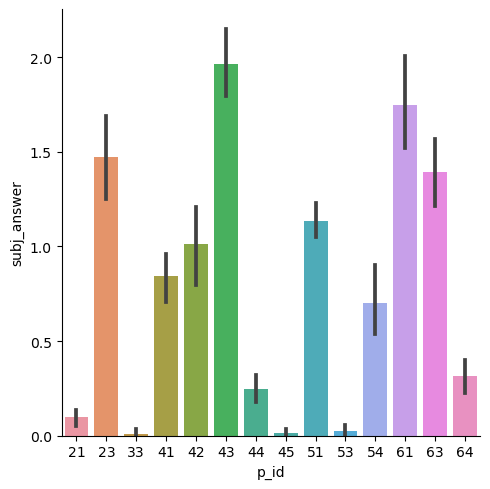

In [66]:
# 1.1.1
sb.catplot(data=all_trials, kind='bar', x='p_id', y='subj_answer')
average_answers_p = pd.DataFrame(all_trials.groupby('p_id', as_index=False)['subj_answer'].mean())
display(average_answers_p)
#ax = sb.displot(data=all_trials, x='subj_answer', col='p_id', kde=True)
#ax.set(ylim=(0,200))
#ax.set_titles("Participant: {col_name}")
#ax.fig.subplots_adjust(top=.87)
#ax.fig.suptitle("Subjective answer counts")

/home/croniev/anaconda3/envs/levinana/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/croniev/anaconda3/envs/levinana/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/croniev/anaconda3/envs/levinana/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))


Text(0.5, 0.98, 'Mean subjective answer over blocks')

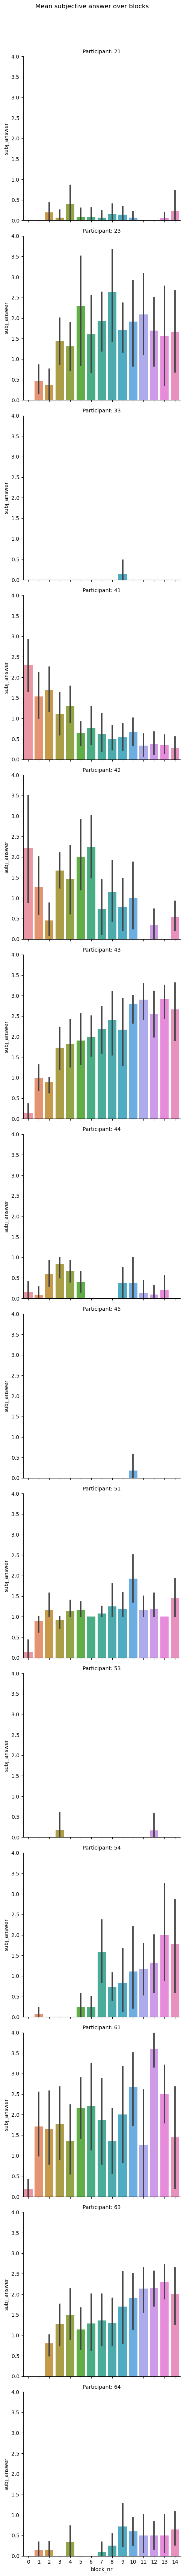

In [67]:
# 1.1.2
ax = sb.catplot(data=all_trials, kind="bar", x="block_nr", y="subj_answer", row="p_id")
ax.set(ylim=(0,4))
ax.set_titles("Participant: {row_name}")
ax.fig.subplots_adjust(top=.96)
ax.fig.suptitle("Mean subjective answer over blocks")

## 1.2 Disturbtion force und subjective answer

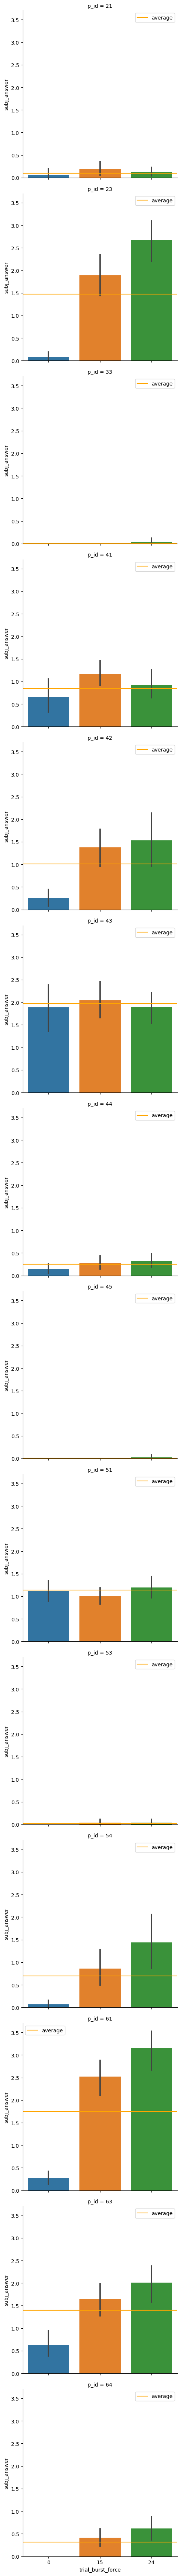

In [87]:
# 1.2.1 ans(force)
average_answers_force = pd.DataFrame(all_trials.groupby(['p_id', 'trial_burst_force','block_nr'], as_index=False)['subj_answer'].mean())
average_answers_force['trial_burst_force'] = average_answers_force['trial_burst_force'].abs()
plot121 = sb.catplot(data=average_answers_force, kind='bar', x='trial_burst_force', y='subj_answer', row='p_id')
for avg, ax in zip(list(average_answers_p['subj_answer']), plot121.axes.flat):
    ax.axhline(avg, color='orange', label='average')
    ax.legend()

In [9]:
# 1.2.1 force(ans)
average_answers_force = pd.DataFrame(all_trials.groupby(['p_id', 'trial_burst_force','block_nr'], as_index=False)['subj_answer'].mean())
plot121 = sb.displot(data=average_answers_force,x='trial_burst_force', col='subj_answer', row='p_id')

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7ff022533c10> (for post_execute):


KeyboardInterrupt: 

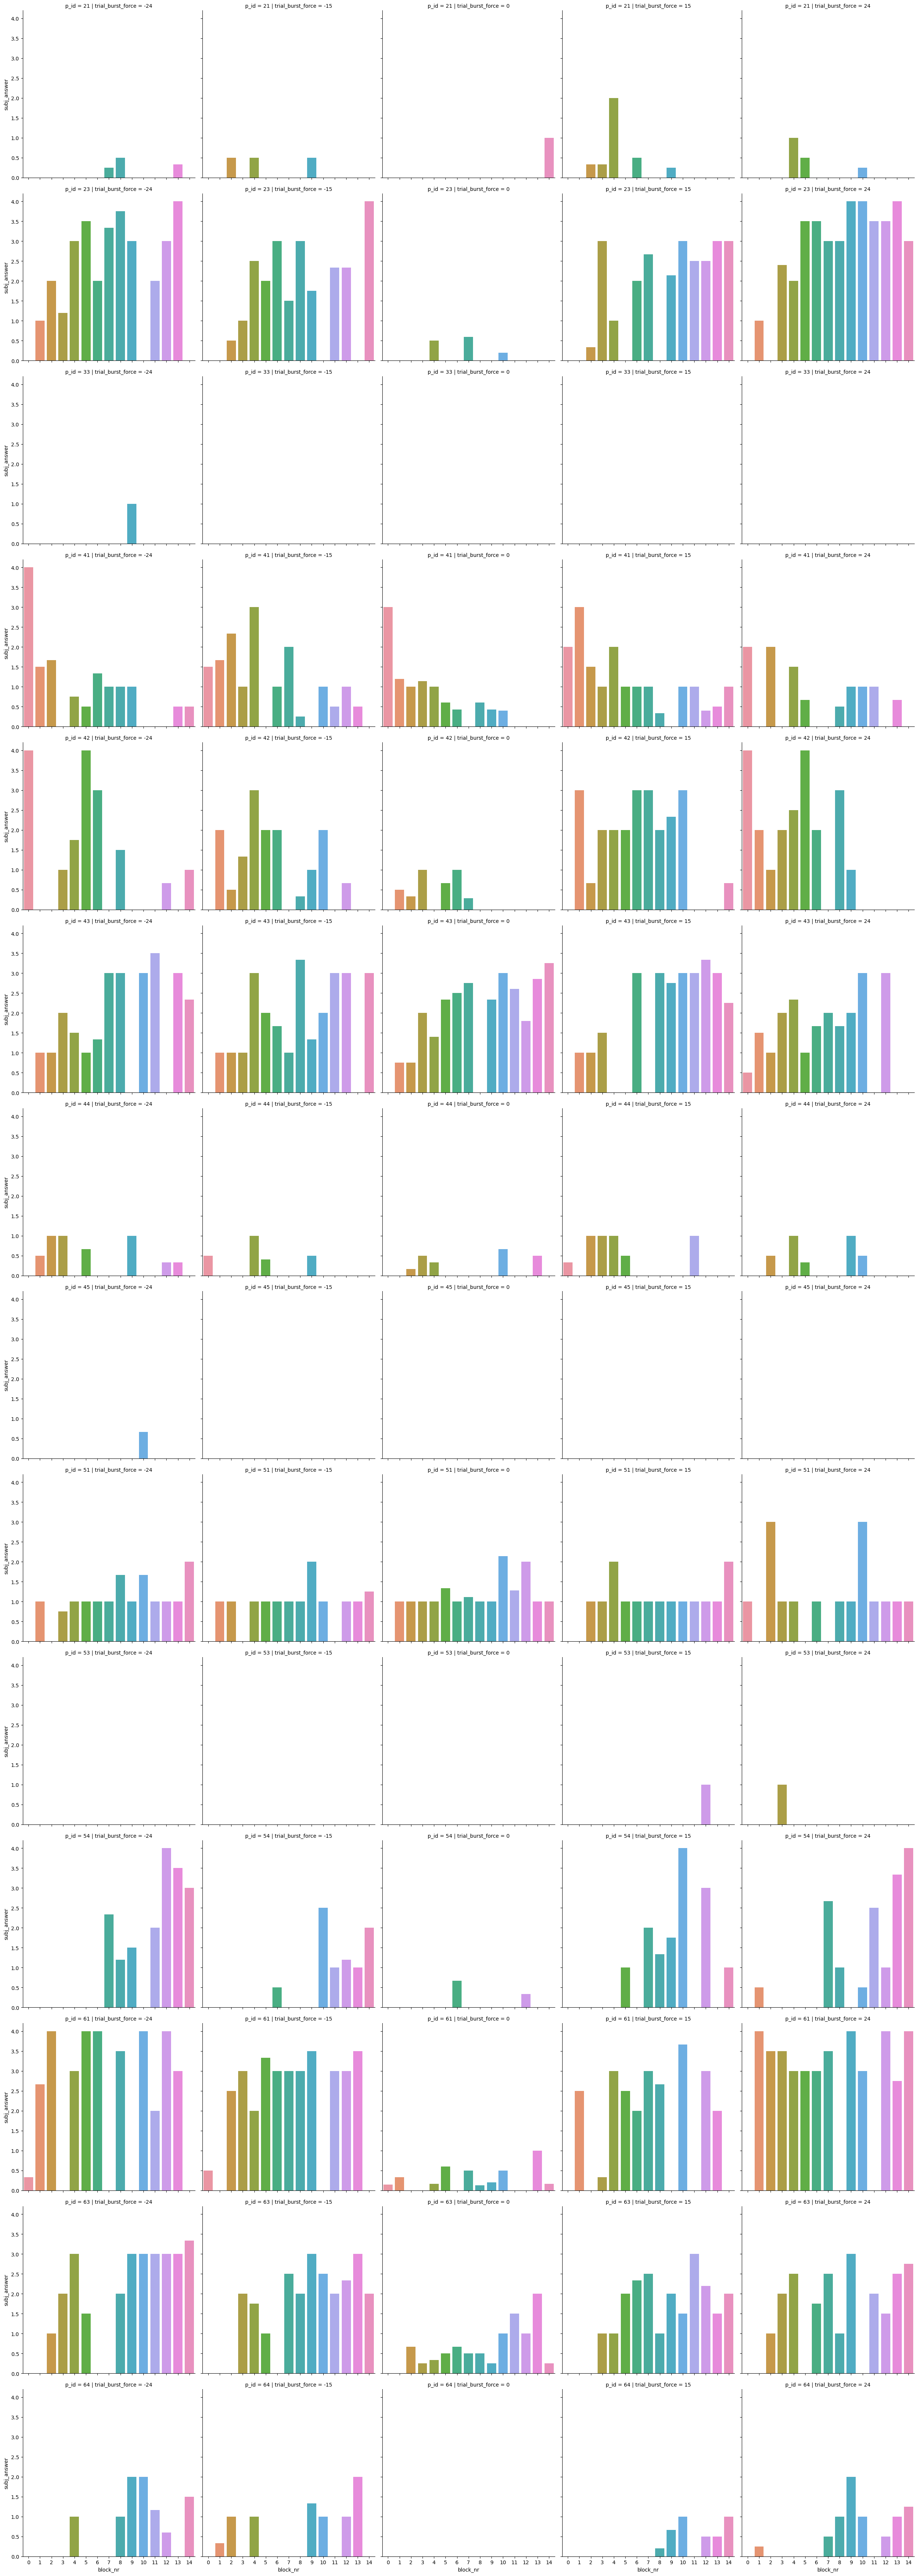

In [69]:
# 1.2.1.1
sb.catplot(data=average_answers_force, kind='bar', x='block_nr', y='subj_answer', row='p_id', col='trial_burst_force')

# 2. Proprioceptive Reporting (PR)

## 2.1 Baseline and zero-force mean

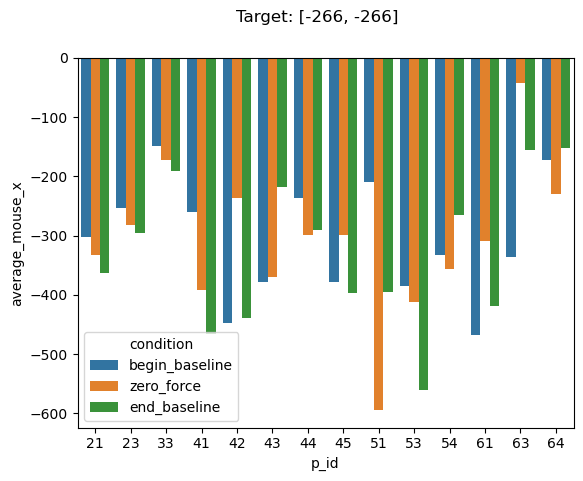

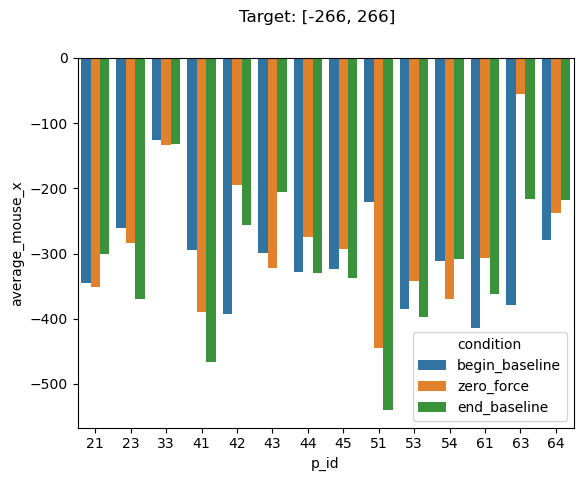

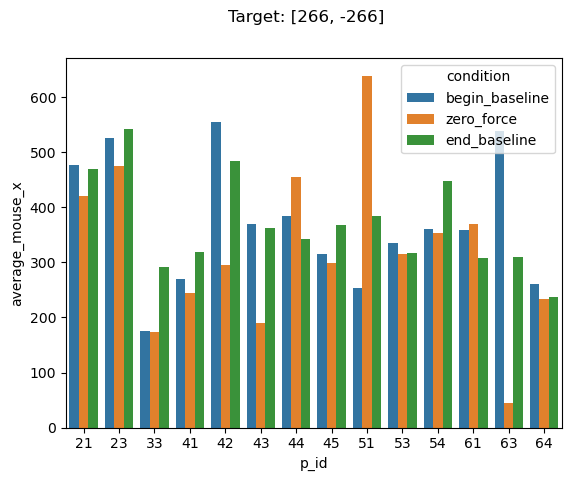

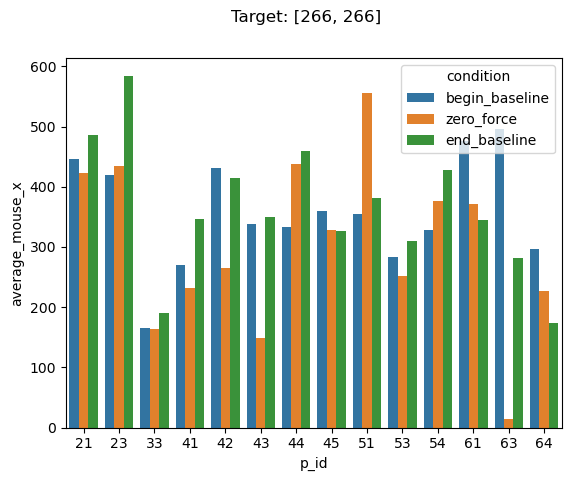

In [70]:
# 2.1.1
avg_mouse_pos = pd.DataFrame(all_begin.groupby(['p_id', 'pr_target'], as_index=False)['pr_mouse_pos_x'].mean())
avg_mouse_pos.rename({'pr_mouse_pos_x': 'begin_baseline'}, axis=1, inplace=True)
avg_mouse_pos['zero_force'] = list(all_trials[all_trials['trial_burst_force']==0].groupby(['p_id', 'pr_target'])['pr_mouse_pos_x'].mean())
avg_mouse_pos['end_baseline'] = list(all_end.groupby(['p_id', 'pr_target'])['pr_mouse_pos_x'].mean())
#display(avg_mouse_pos)

for pos in list(avg_mouse_pos['pr_target'].unique()):
    melted = avg_mouse_pos[avg_mouse_pos['pr_target'] == pos][['p_id', 'begin_baseline', 'zero_force', 'end_baseline']].melt('p_id', var_name='condition', value_name='average_mouse_x')
    plt.figure()
    plot211 = sb.barplot(data=melted, x='p_id', y='average_mouse_x', hue='condition')
    plot211.figure.suptitle(f'Target: {pos}')

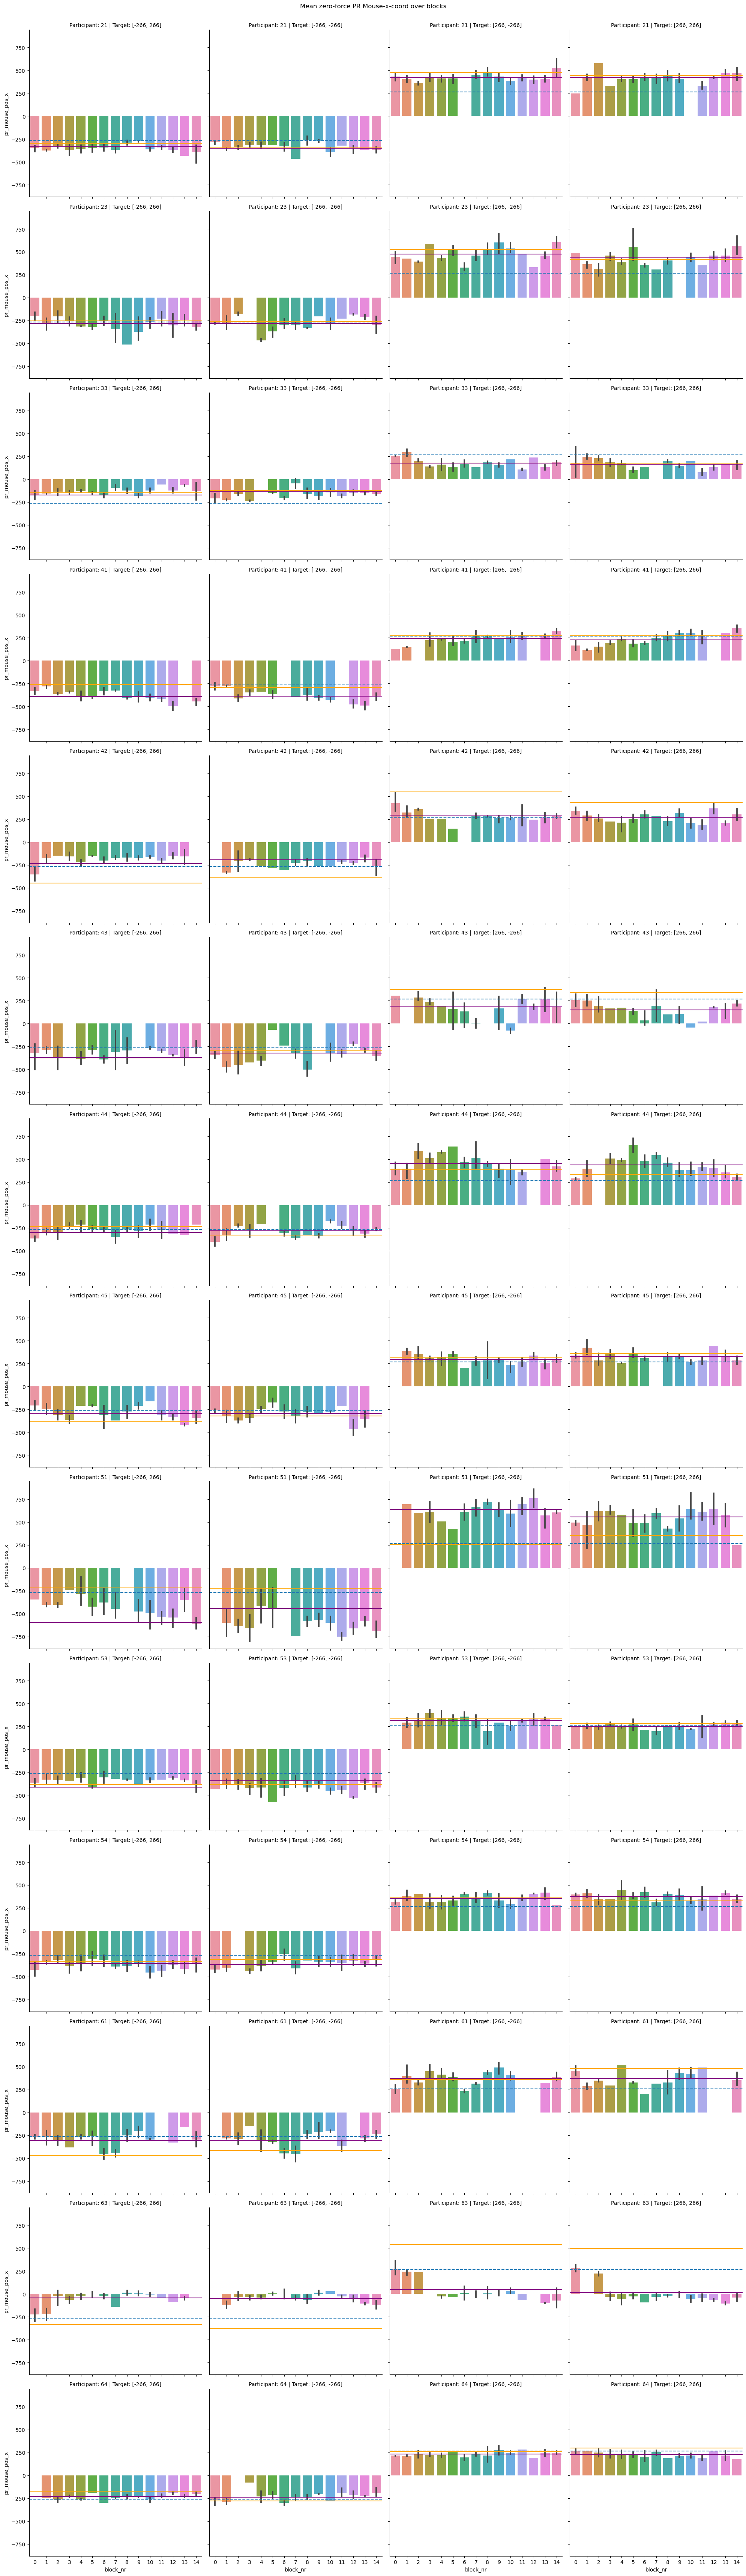

In [71]:
# 2.1.1.1
plot212 = sb.catplot(data=all_trials[all_trials['trial_burst_force']==0], kind="bar", x="block_nr", y="pr_mouse_pos_x", col="pr_target", row="p_id")
plot212.set_titles(col_template="Target: {col_name}", row_template='Participant: {row_name}')
plot212.fig.subplots_adjust(top=.97)
plot212.fig.suptitle("Mean zero-force PR Mouse-x-coord over blocks")

for axis, p_id in zip(plot212.axes, p_ids):
    for i, plot in enumerate(axis):
        if i < 2:
            plot.axhline(-266, ls='--')
        else:
            plot.axhline(266, ls='--')
        plot.axhline(avg_mouse_pos[avg_mouse_pos['p_id'] == p_id].iloc[i]['begin_baseline'], color='orange', label='Average base1')
        plot.axhline(avg_mouse_pos[avg_mouse_pos['p_id'] == p_id].iloc[i]['zero_force'], color='purple', label='Average zero-force')
        

## 2.2 Leistung nach force

Text(0.5, 0.98, 'x-axis offset averages')

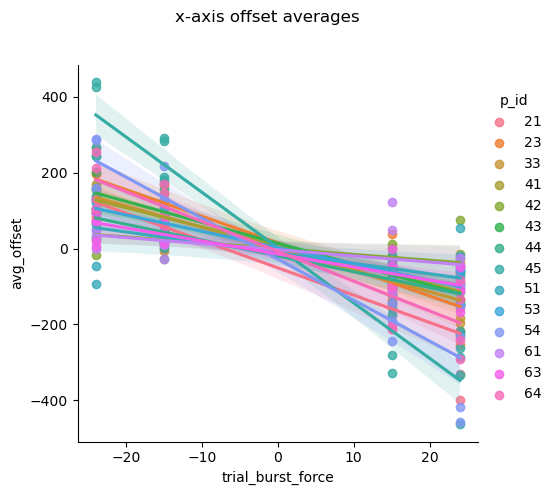

In [72]:
# 2.2
grouped_avg_dist_force = pd.DataFrame(all_trials.groupby(['p_id', 'pr_target', 'trial_burst_force'], as_index=False)['pr_mouse_pos_x'].mean())
all_sorted_pr = all_trials[['p_id', 'pr_target', 'trial_burst_force', 'pr_mouse_pos_x', 'block_nr']].copy().sort_values(['p_id', 'pr_target'])
tmp1 = []
tmp2 = []
for p_id in p_ids:
    for pos in ['[-266, -266]', '[-266, 266]', '[266, -266]', '[266, 266]']:
        tmp1 += list(grouped_avg_dist_force[(grouped_avg_dist_force['p_id'] == p_id) & (grouped_avg_dist_force['pr_target'] == pos)]['pr_mouse_pos_x'] - grouped_avg_dist_force[(grouped_avg_dist_force['p_id'] == p_id) & (grouped_avg_dist_force['pr_target'] == pos) & (grouped_avg_dist_force['trial_burst_force'] == 0)]['pr_mouse_pos_x'].iloc[0])
        tmp2 += list(all_sorted_pr[(all_sorted_pr['p_id'] == p_id) & (all_sorted_pr['pr_target'] == pos)]['pr_mouse_pos_x'] - grouped_avg_dist_force[(grouped_avg_dist_force['p_id'] == p_id) & (grouped_avg_dist_force['pr_target'] == pos) & (grouped_avg_dist_force['trial_burst_force'] == 0)]['pr_mouse_pos_x'].iloc[0])
        
grouped_avg_dist_force['avg_offset'] = tmp1
all_sorted_pr['avg_offset'] = tmp2

ga_plt = sb.lmplot(data=grouped_avg_dist_force, x="trial_burst_force", y="avg_offset", hue="p_id")
ga_plt.fig.subplots_adjust(top=.87)
ga_plt.fig.suptitle("x-axis offset averages")

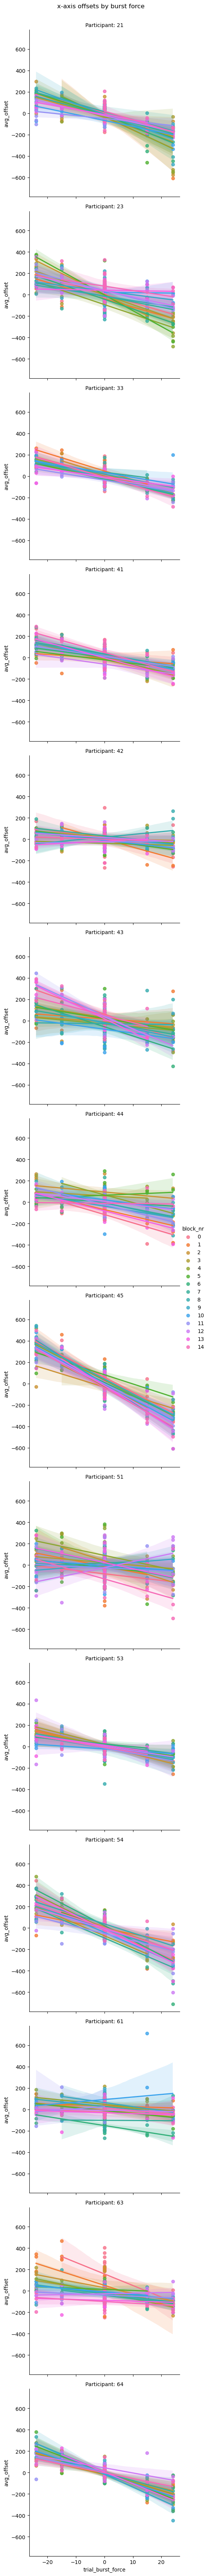

In [73]:
# 2.2.1
asp_plt = sb.lmplot(data=all_sorted_pr, x="trial_burst_force", y="avg_offset", row="p_id", hue='block_nr')
asp_plt.fig.subplots_adjust(top=.97)
asp_plt.fig.suptitle("x-axis offsets by burst force")
asp_plt.set_titles("Participant: {row_name}")

## 2.3 Subjektive Wahrnehmung 

### 2.3.1 Zero-force und zero-feel

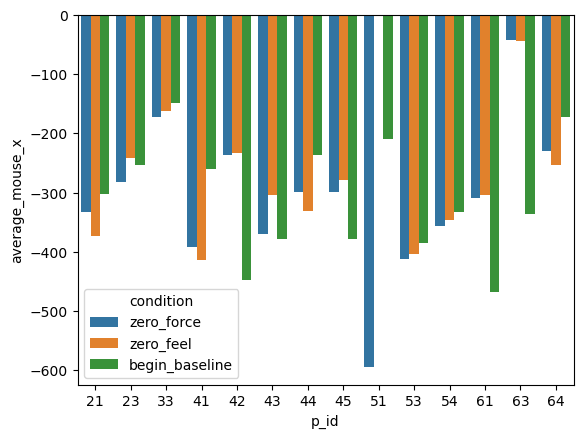

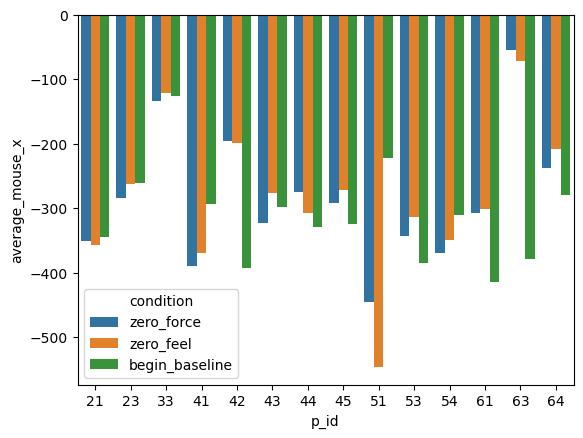

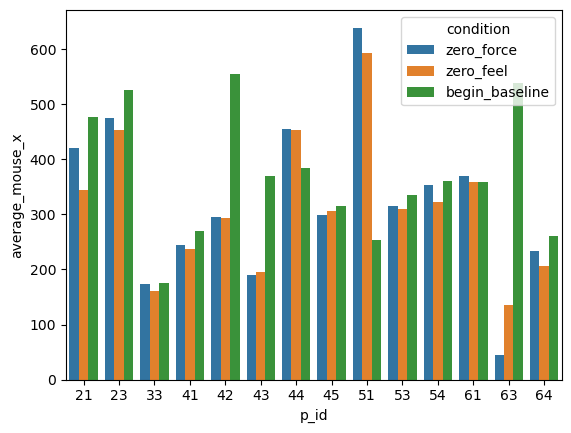

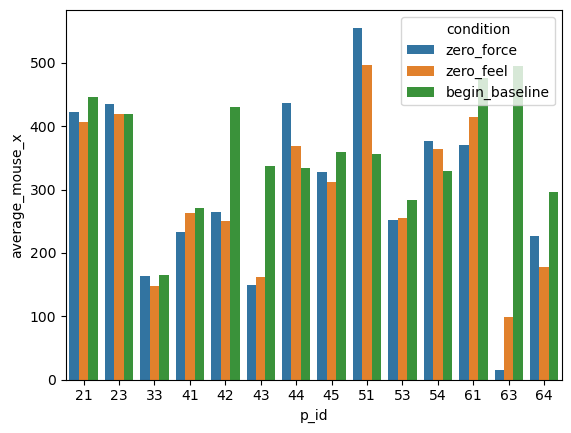

In [74]:
tmp = []
for x in itertools.product(grouped_avg_dist_force['p_id'].unique(), grouped_avg_dist_force['pr_target'].unique()):
    #m = grouped_zfeel[(grouped_zfeel['p_id']==x[0]) & (grouped_zfeel['pr_target']==x[1])]['pr_mouse_pos_x']
    m = all_trials[(all_trials['p_id']==x[0]) & (all_trials['pr_target']==x[1]) & (all_trials['subj_answer']==0)]['pr_mouse_pos_x'].mean()
    tmp.append(m)

avg_mouse_pos['zero_feel'] = tmp
avg_mouse_pos['force_minus_feel'] = avg_mouse_pos['zero_force'] - avg_mouse_pos['zero_feel']

for pos in list(avg_mouse_pos['pr_target'].unique()):
    melted = avg_mouse_pos[avg_mouse_pos['pr_target'] == pos][['p_id', 'zero_force', 'zero_feel', 'begin_baseline']].melt('p_id', var_name='condition', value_name='average_mouse_x')
    plt.figure()
    sb.barplot(data=melted, x='p_id', y='average_mouse_x', hue='condition')

### 2.3.2 Leistung nach Subjektiver Wahrnehmung

Text(0.5, 0.98, 'x-axis offset averages')

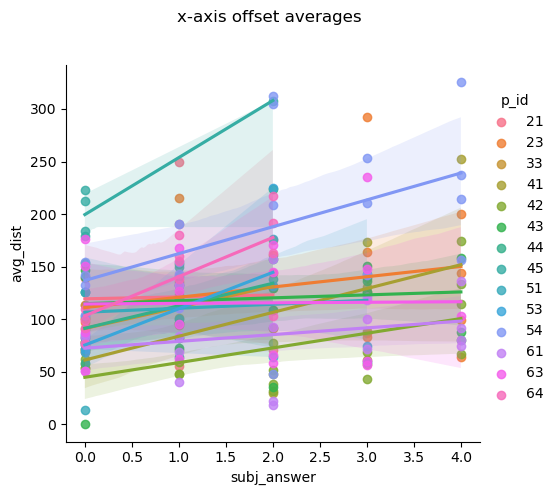

In [75]:
# 2.3.2
zero_feel_pos = pd.DataFrame(all_trials[all_trials['subj_answer'] == 0].groupby(['p_id', 'pr_target'], as_index=False)['pr_mouse_pos_x'].mean())
grouped_avg_dist_feel = pd.DataFrame()
for p_id in p_ids:
    for pos in ['[-266, -266]', '[-266, 266]', '[266, -266]', '[266, 266]']:
        zero_feel = zero_feel_pos[(zero_feel_pos['p_id'] == p_id) & (zero_feel_pos['pr_target'] == pos)]['pr_mouse_pos_x']
        if len(zero_feel) != 0:
            t_minus_zero = all_trials[(all_trials['p_id']==p_id) & (all_trials['pr_target']==pos)].copy()
            t_minus_zero['pr_mouse_pos_x'] = (t_minus_zero['pr_mouse_pos_x'] - zero_feel.iloc[0]).abs()
            t_minus_zero = pd.DataFrame(t_minus_zero.groupby(['p_id', 'pr_target', 'subj_answer'], as_index=False)['pr_mouse_pos_x'].mean())
            grouped_avg_dist_feel = pd.concat((grouped_avg_dist_feel, t_minus_zero))
grouped_avg_dist_feel.rename({'pr_mouse_pos_x': 'avg_dist'}, axis=1, inplace=True)
plot232 = sb.lmplot(data=grouped_avg_dist_feel, x="subj_answer", y="avg_dist", hue="p_id")
plot232.fig.subplots_adjust(top=.87)
plot232.fig.suptitle("x-axis offset averages")

## 2.4 Visuelle und tatsächliche information

### 2.4.1 Letzte tatsächliche position

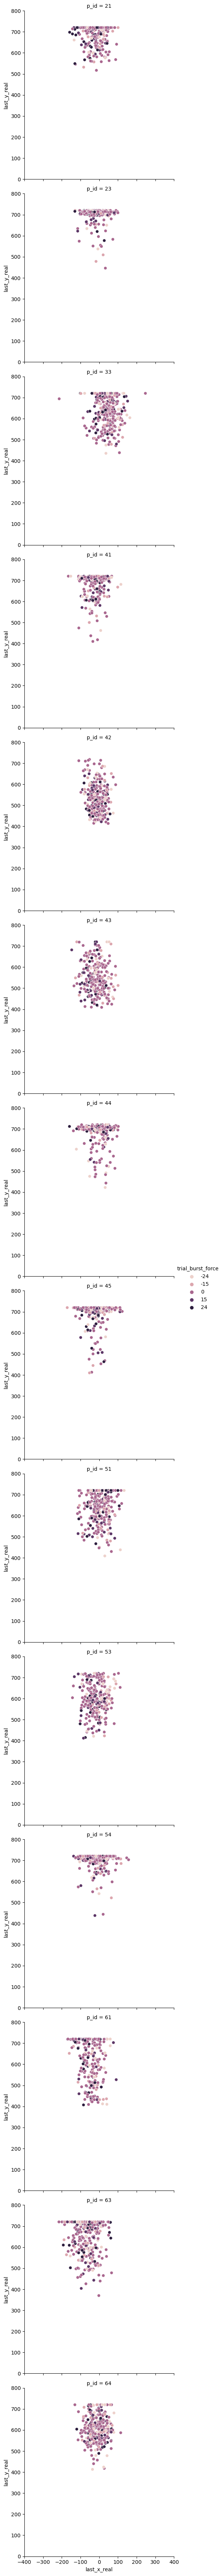

In [76]:
# 2.4.1
plot241 = sb.relplot(data=all_trials, x='last_x_real', y='last_y_real', row='p_id', hue='trial_burst_force')
plot241.set(ylim=(0,800), xlim=[-400,400])
avg_x = pd.DataFrame(all_trials.groupby(['p_id', 'trial_burst_force'], as_index=False)['last_x_real'].mean())

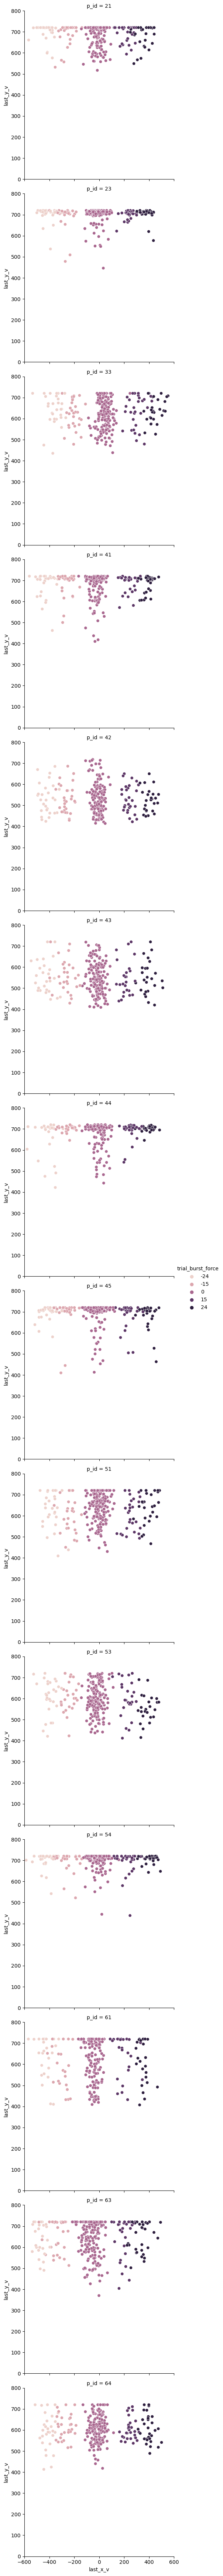

In [77]:
plot241 = sb.relplot(data=all_trials, x='last_x_v', y='last_y_v', row='p_id', hue='trial_burst_force')
plot241.set(ylim=(0,800), xlim=[-600,600])
avg_x['last_x_v'] = list(all_trials.groupby(['p_id', 'trial_burst_force'])['last_x_v'].mean())

In [78]:
display(avg_x)

p_id  trial_burst_force  last_x_real    last_x_v
0     21                -24   -17.533333 -422.333333
1     21                -15     2.366667 -253.133333
2     21                  0    -9.589888   -9.589888
3     21                 15   -39.933333  213.566667
4     21                 24   -53.700000  359.100000
..   ...                ...          ...         ...
65    64                -24    -1.137931 -411.620690
66    64                -15   -12.068966 -269.655172
67    64                  0   -12.626437  -12.626437
68    64                 15    -9.689655  245.827586
69    64                 24   -14.666667  397.333333

[70 rows x 4 columns]

### 2.4.2 Click-movement im Vergleich mit zero-force (und zero-feel)

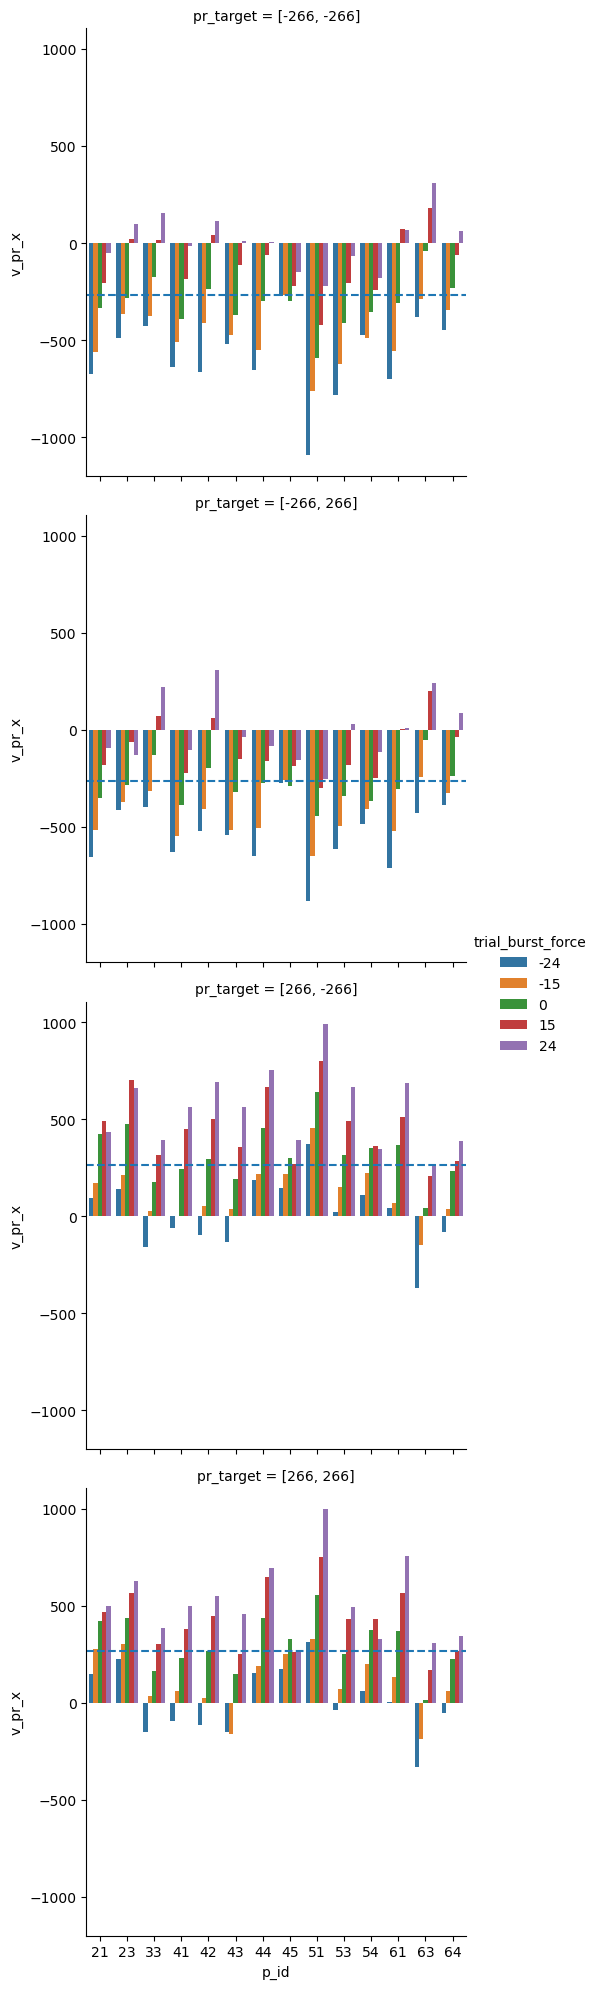

In [79]:
# 2.4.2
all_trials['burst_offset'] = all_trials['last_x_v'] - all_trials['last_x_real']
all_trials['v_pr_x'] = all_trials['pr_mouse_pos_x'] + all_trials['burst_offset']
#display(all_trials)
avg_v_move = pd.DataFrame(all_trials.groupby(['p_id', 'pr_target', 'trial_burst_force'], as_index=False)['v_pr_x'].mean())

plot242 = sb.catplot(kind='bar', data=avg_v_move, x='p_id', row='pr_target', y='v_pr_x', hue='trial_burst_force')
for i, p in enumerate(plot242.axes.flat):
    v=1
    if i<2:
        v=-1
    p.axhline(v*266, ls='--', label='target')

# 3. SSS Questionnaire

## 3.1 SSS und Antwort

In [80]:
# Daten der questionnaires einlesen
quest2 = [pd.read_csv(f"./data/{p_id}/2_questionnaire.csv") for p_id in p_ids]
for p_id, q in zip(p_ids, quest2):
    q['p_id'] = p_id

all_quest2 = pd.concat(quest2, ignore_index=True)
all_quest2 = all_quest2[all_quest2['response'].notna()]

Text(0.5, 1.0, 'Score on SSS+SPQ test vs. average subjective answer')

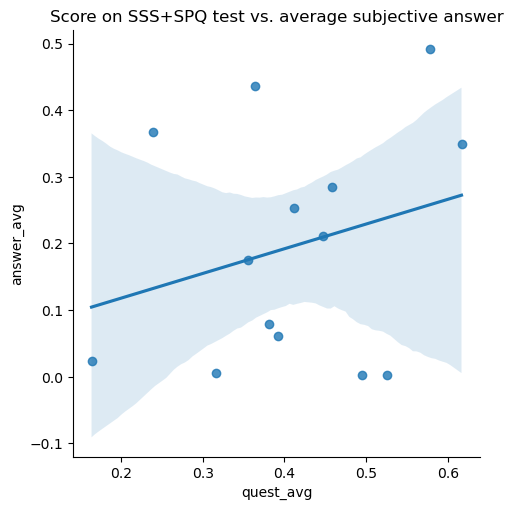

In [81]:
# 4.1
# Average questionnaire score
quest_scores = pd.DataFrame(p_ids, columns = ['p_id'])
quest_scores['quest_avg'] = [(q[1:10]['response'].mean()/4 + q[11:]['response'].mean()/3)/2 for q in quest2]
quest_scores['answer_avg'] = list(all_trials.groupby('p_id')['subj_answer'].mean()/4)
sb.lmplot(data=quest_scores, x='quest_avg', y='answer_avg')
plt.title('Score on SSS+SPQ test vs. average subjective answer')

## 3.2 SSS und Leistung

p_id  quest_avg  answer_avg      pr_avg  pr_avg_feel
0     21   0.163889    0.023990  139.593128   120.946368
1     23   0.238889    0.368056  136.698413   130.713598
2     33   0.494444    0.002660  111.619172    99.306421
3     41   0.447222    0.210526   98.802232    98.587915
4     42   0.411111    0.252874   44.784912    72.775931
5     43   0.577778    0.491279  111.273760   120.109551
6     44   0.391667    0.061404   76.523661   108.586933
7     45   0.525000    0.002809  286.872759   221.274318
8     51   0.458333    0.284286   82.937605   112.230198
9     53   0.316667    0.005618   86.777951    98.535656
10    54   0.355556    0.174855  209.503580   186.667615
11    61   0.363889    0.436747   52.779911    85.429321
12    63   0.616667    0.348870   67.824019   115.478960
13    64   0.380556    0.078534  155.332077   140.571858

Text(0.5, 1.0, 'Score on SSS+SPQ test vs. average distance under force to zero-force x mean')

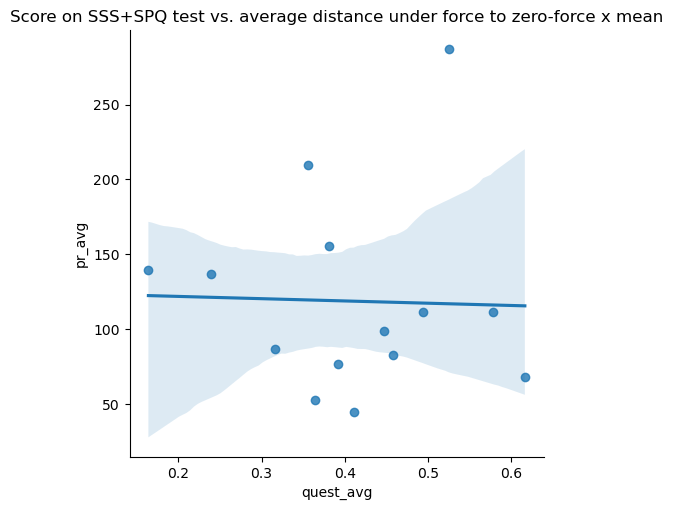

In [82]:
# 4.2
# Average PR score
tmp = []
for p_id in p_ids:
    tmp += [grouped_avg_dist_force[(grouped_avg_dist_force['p_id']==p_id) & (grouped_avg_dist_force['trial_burst_force']!=0)]['avg_offset'].abs().mean()]
quest_scores['pr_avg'] = tmp
quest_scores['pr_avg_feel'] = list(grouped_avg_dist_feel.groupby('p_id')['avg_dist'].mean())
display(quest_scores)
sb.lmplot(data=quest_scores, x='quest_avg', y='pr_avg')
plt.title('Score on SSS+SPQ test vs. average distance under force to zero-force x mean')

# Sonstiges

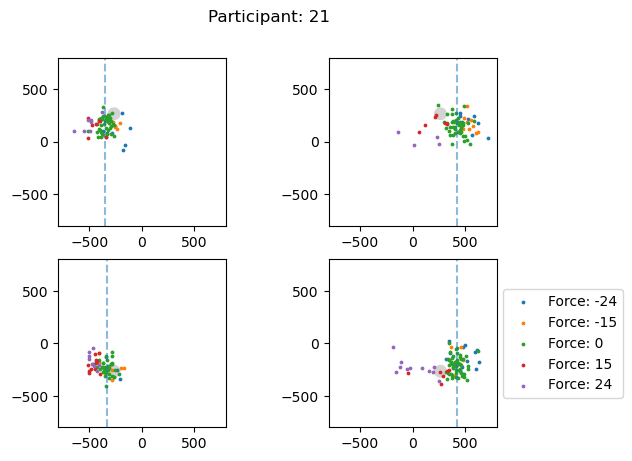

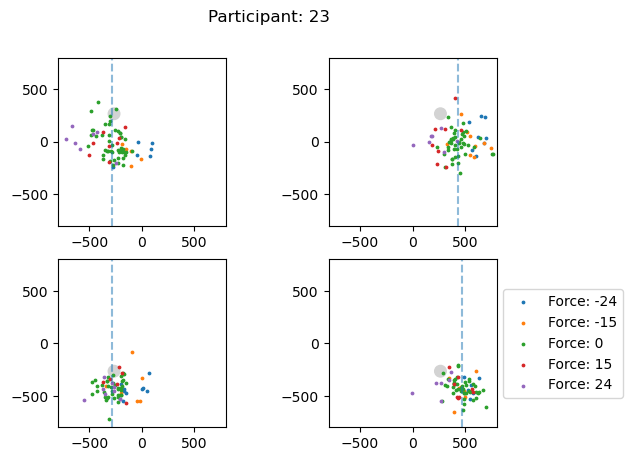

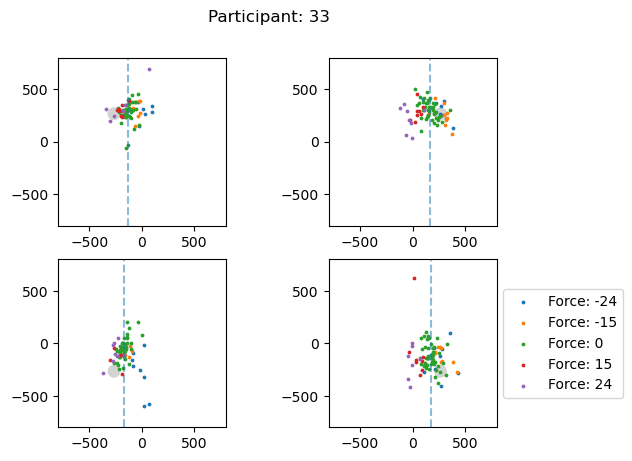

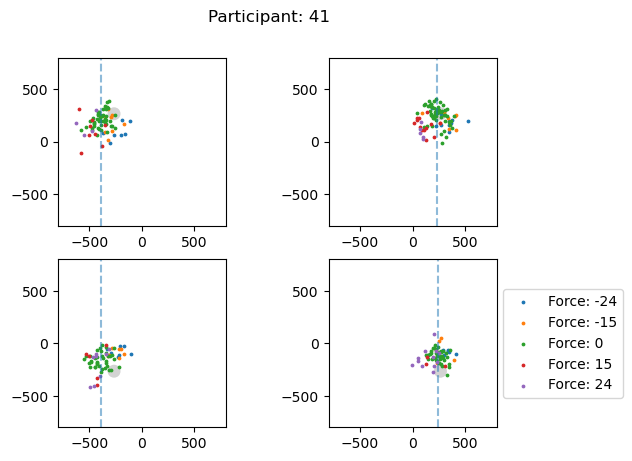

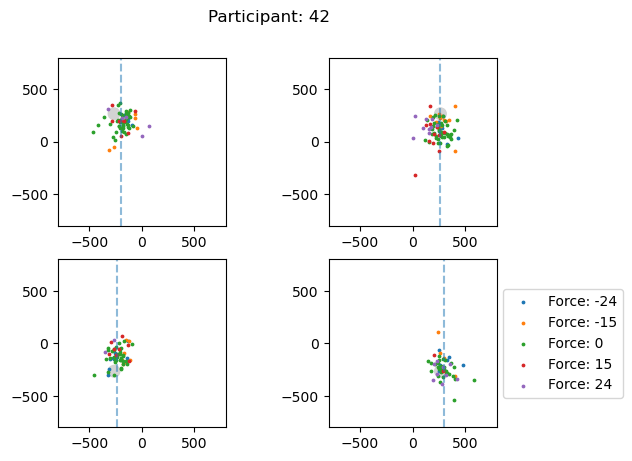

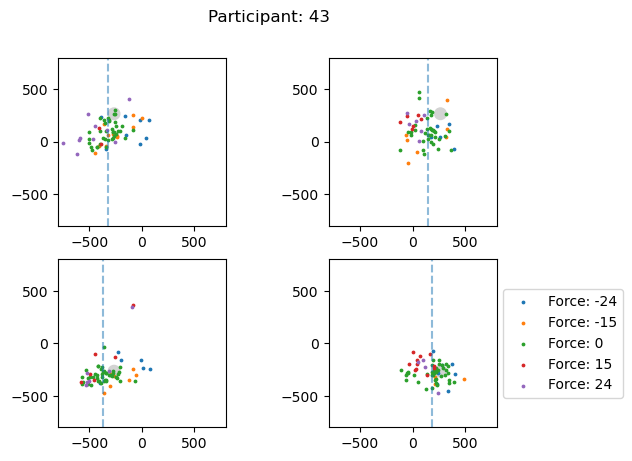

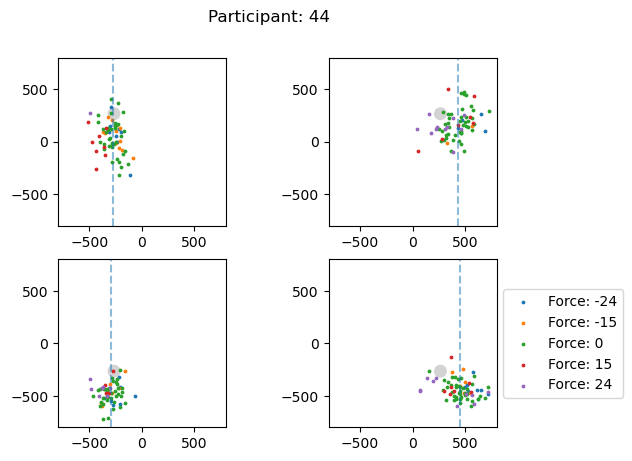

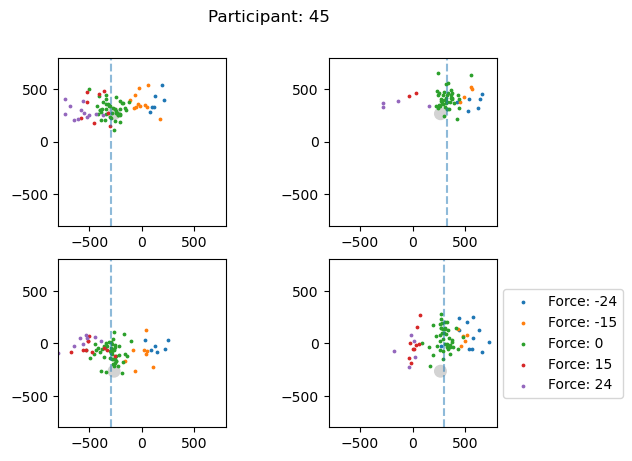

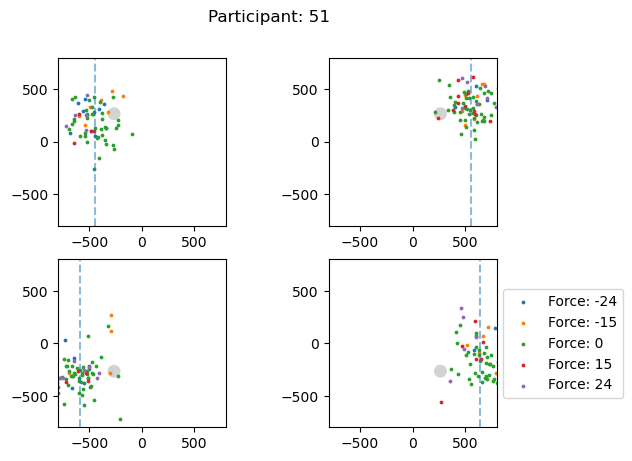

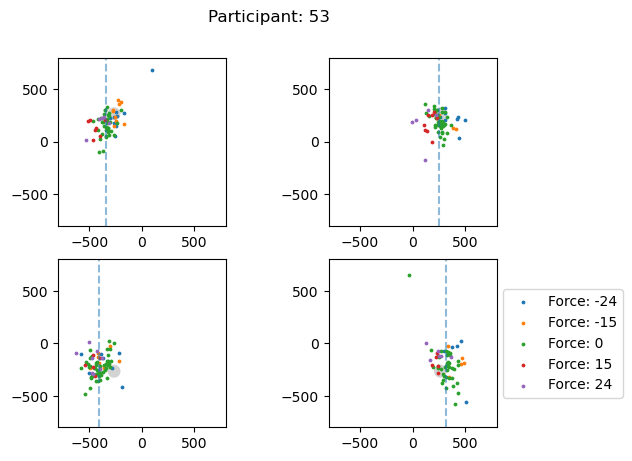

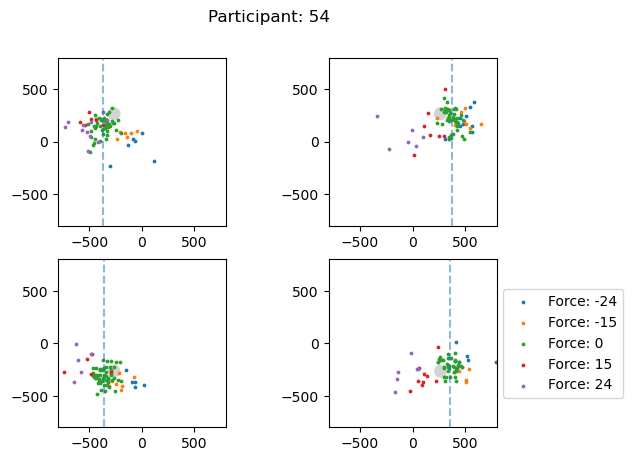

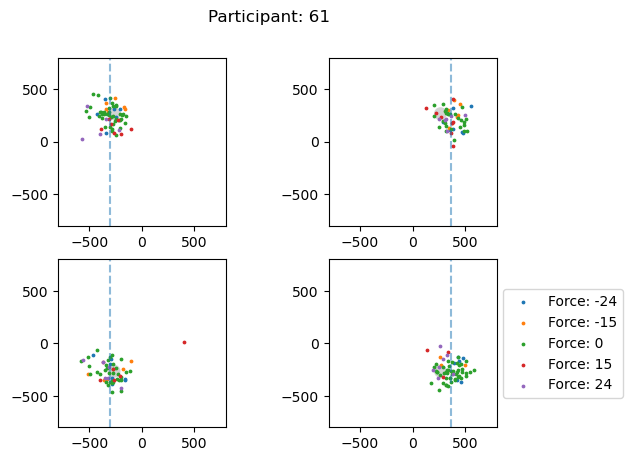

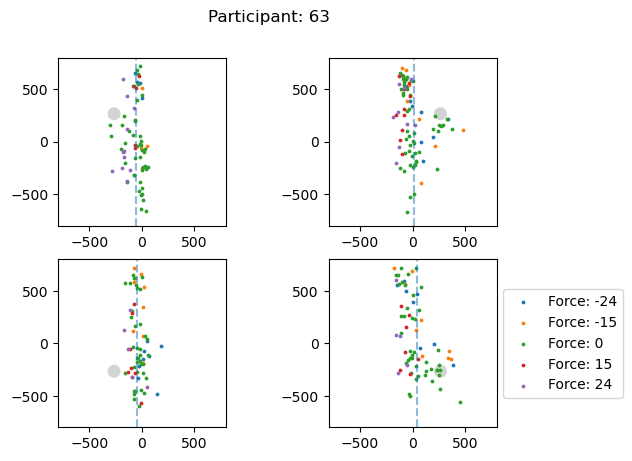

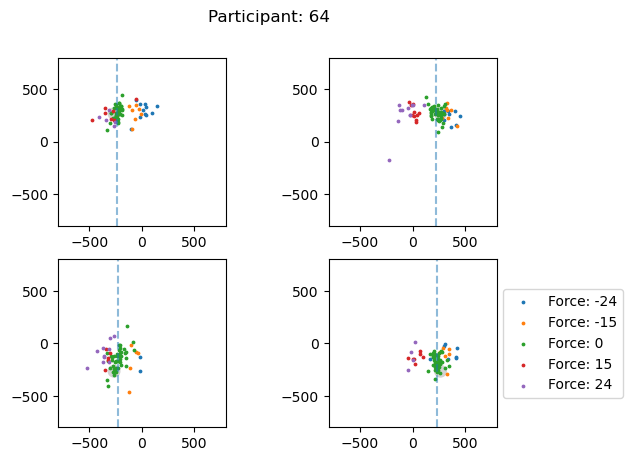

In [84]:
# 2.2
# figs
target_poss = ['[-266, 266]', '[266, 266]', '[-266, -266]', '[266, -266]']
idxs = [(0,0), (0,1), (1,0), (1,1)]

for p_id, trials in zip(p_ids, main_trials):
    fig, ax = plt.subplots(2,2)
    for idx, t in zip(idxs, target_poss):
        data = trials[trials["pr_target"] == t].sort_values("trial_burst_force") 
        cc = plt.Circle(ast.literal_eval(t), 55, color='lightgray') 
        ax[idx[0]][idx[1]].set(xlim=(-800,800), ylim=(-800,800), aspect=1)
        ax[idx[0]][idx[1]].add_artist(cc)
        for f in data["trial_burst_force"].unique():
            x = data[data["trial_burst_force"] == f]["pr_mouse_pos_x"]
            y = data[data["trial_burst_force"] == f]["pr_mouse_pos_y"]
            ax[idx[0]][idx[1]].scatter(x, y, s=3, label=f"Force: {f}")
            if f == 0:
                ax[idx[0]][idx[1]].axvline(x.mean(), alpha=0.5, ls="--")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    fig.suptitle(f"Participant: {p_id}")
    plt.show()

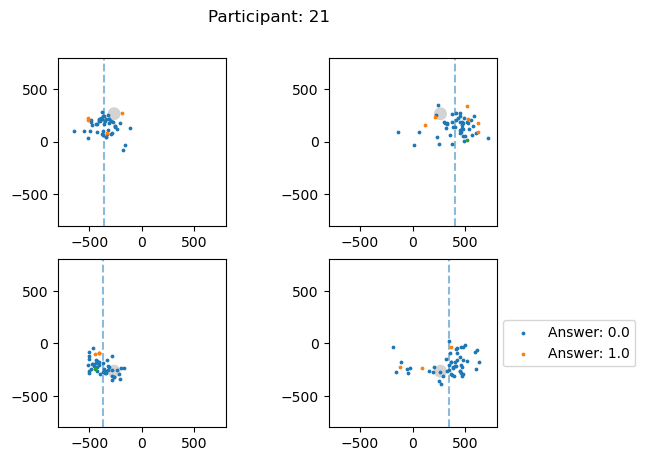

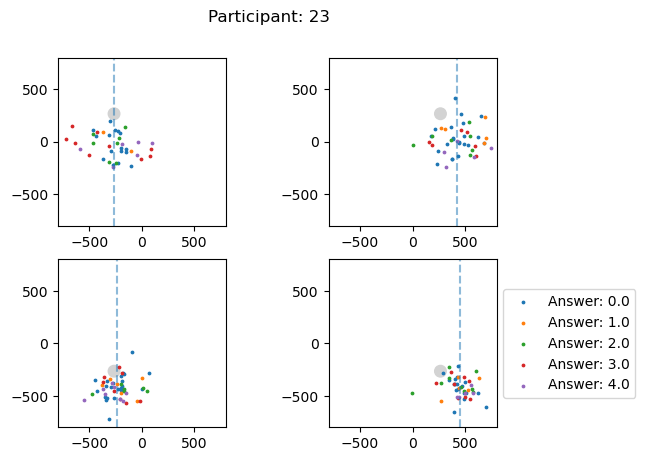

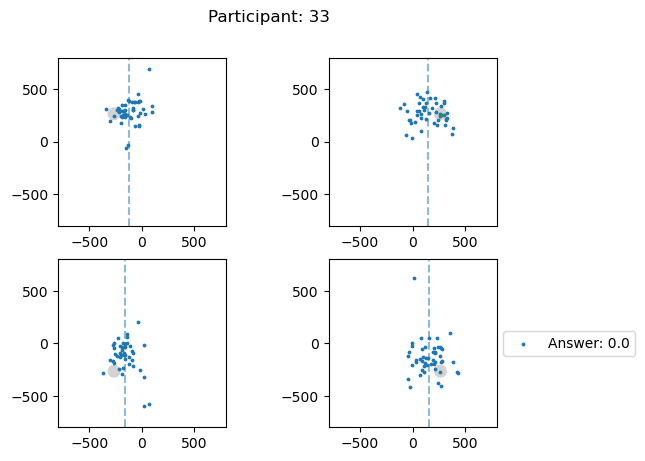

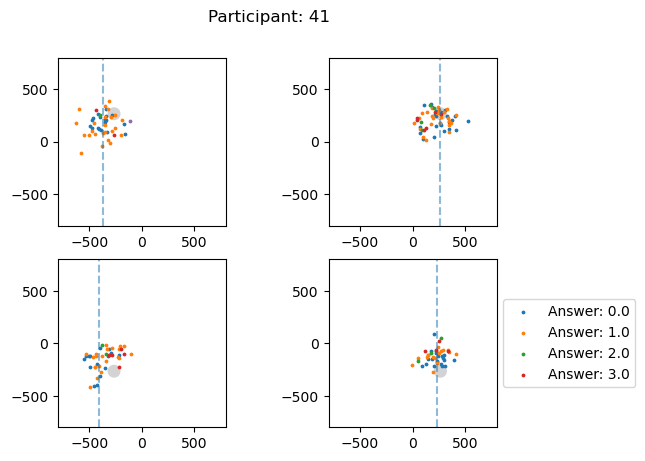

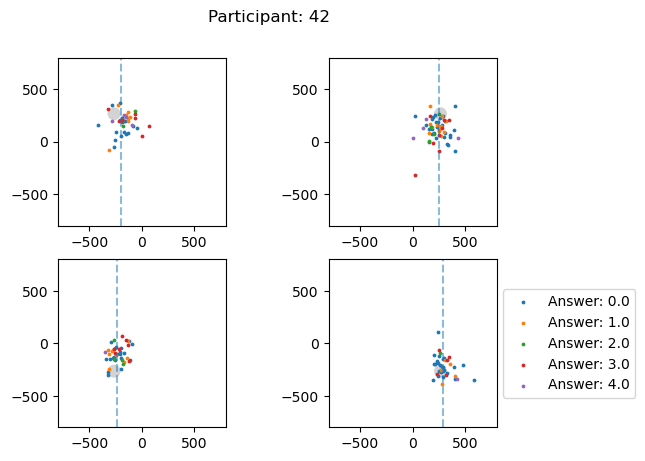

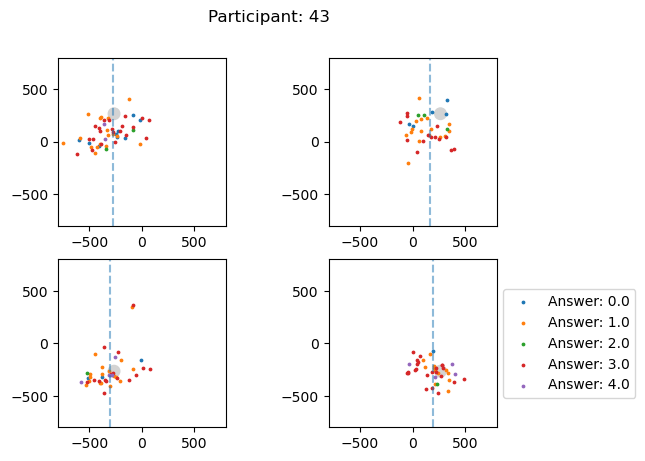

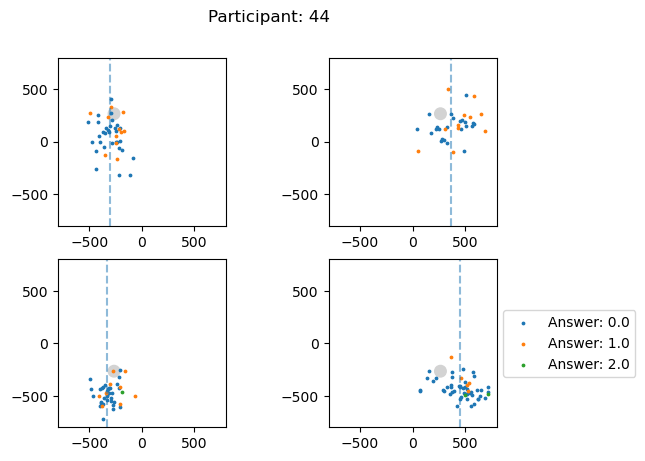

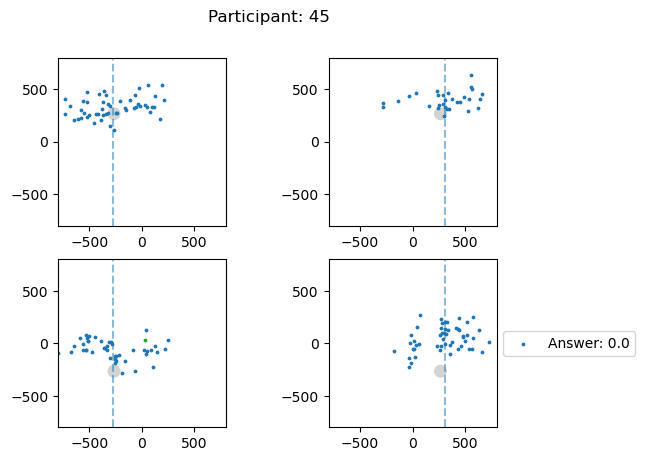

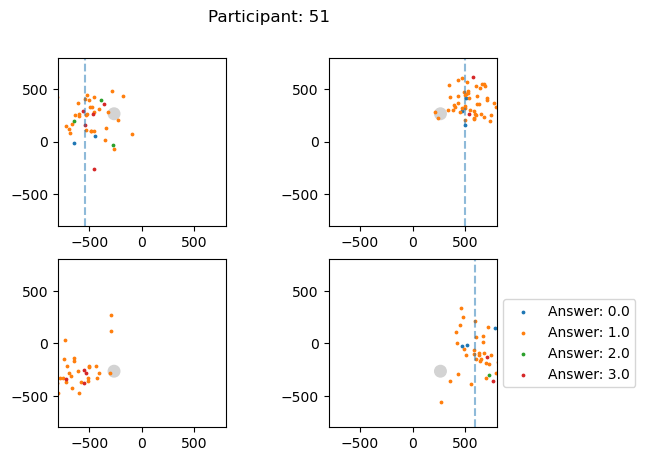

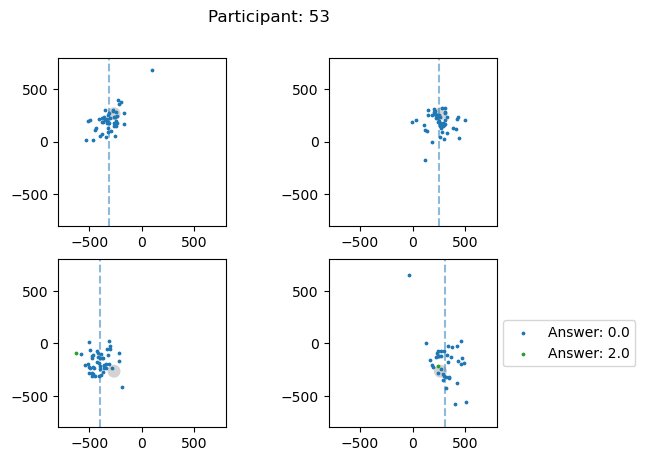

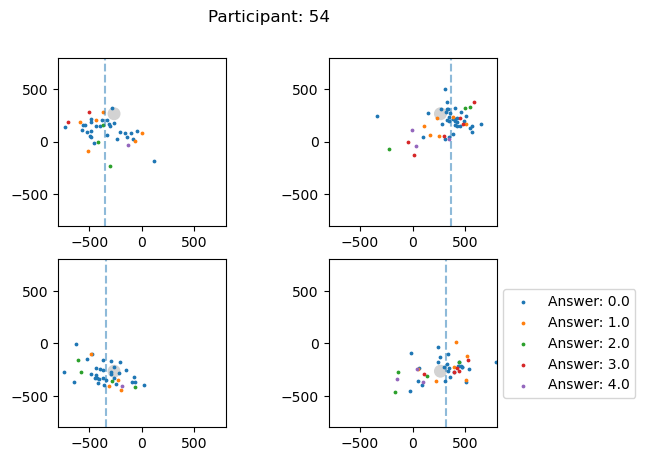

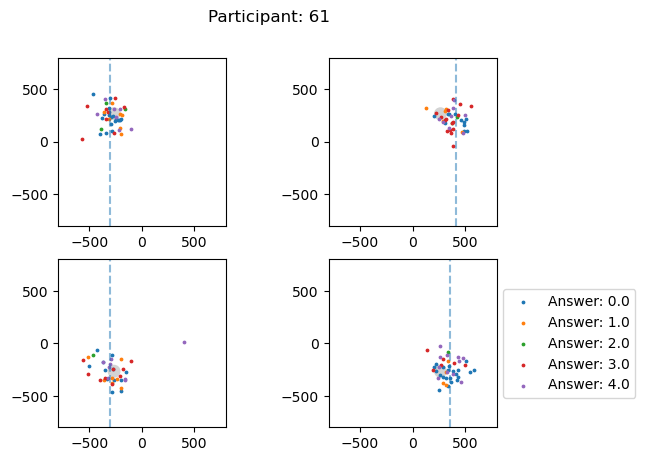

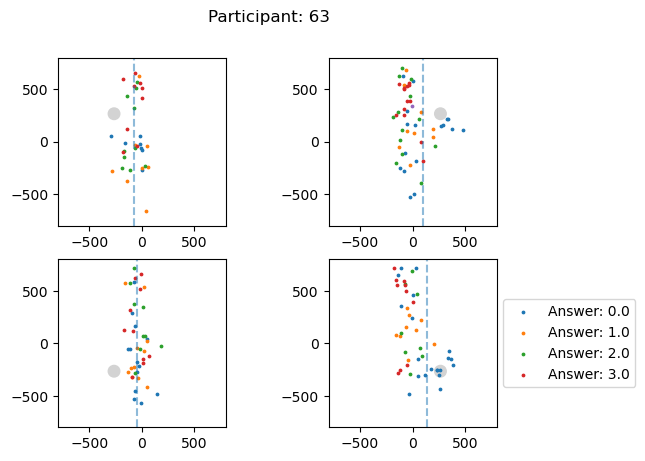

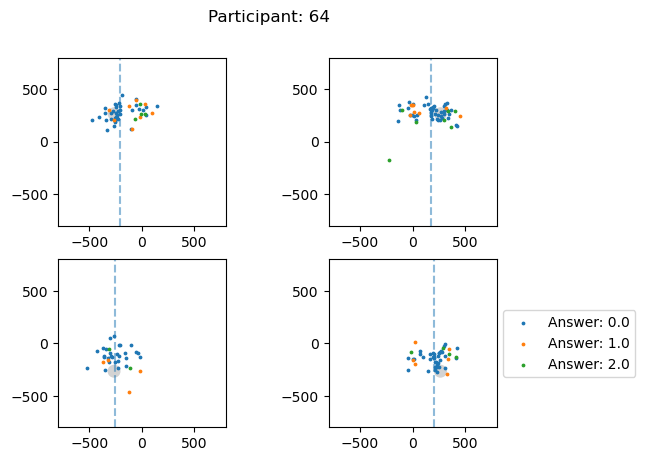

In [85]:
# 2.3.2
# figs
target_poss = ['[-266, 266]', '[266, 266]', '[-266, -266]', '[266, -266]']
idxs = [(0,0), (0,1), (1,0), (1,1)]
colors = {0:'tab:blue',1:'tab:orange',2:'tab:green',3:'tab:red',4:'tab:purple'}

for p_id, trials in zip(p_ids, main_trials):
    fig, ax = plt.subplots(2,2)
    for idx, t in zip(idxs, target_poss):
        data = trials[(trials["pr_target"] == t) & (trials['subj_answer'].notna())].sort_values("subj_answer")
        #data = data[data['block_nr'] >= 10]
        cc = plt.Circle(ast.literal_eval(t), 55, color='lightgray') 
        ax[idx[0]][idx[1]].set(xlim=(-800,800), ylim=(-800,800), aspect=1)
        ax[idx[0]][idx[1]].add_artist(cc)
        for s in data["subj_answer"].unique():
            x = data[data["subj_answer"] == s]["pr_mouse_pos_x"]
            y = data[data["subj_answer"] == s]["pr_mouse_pos_y"]
            ax[idx[0]][idx[1]].scatter(x, y, s=3, label=f"Answer: {s}", color=colors[s])
            if s == 0:
                ax[idx[0]][idx[1]].axvline(x.mean(), alpha=0.5, ls="--")
                
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    fig.suptitle(f"Participant: {p_id}")
    plt.show()

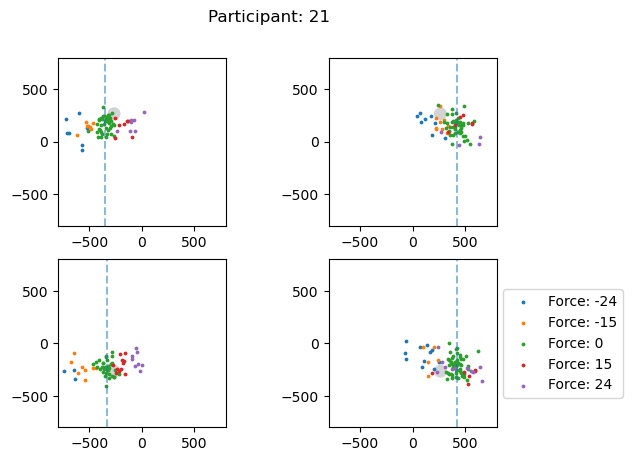

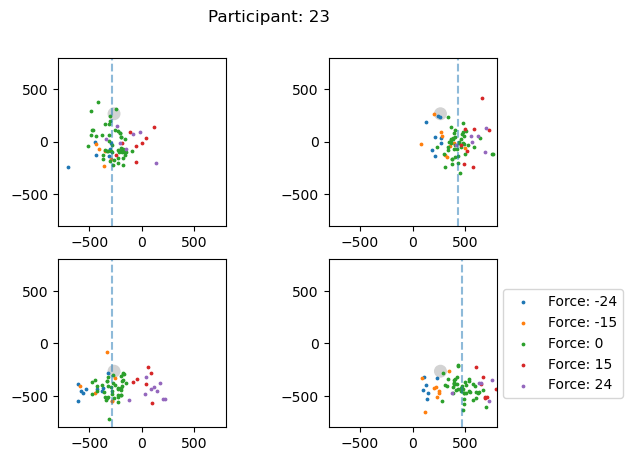

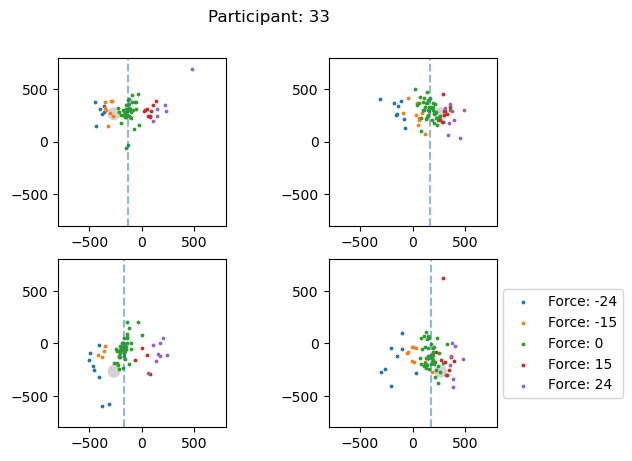

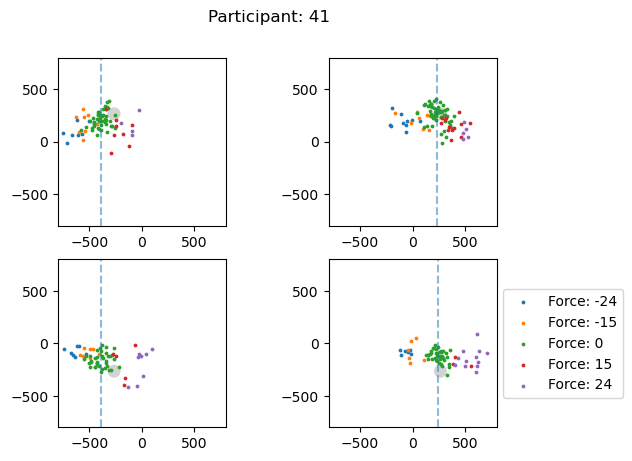

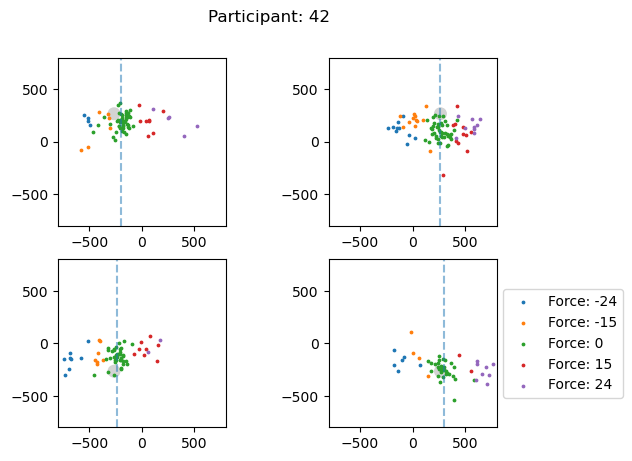

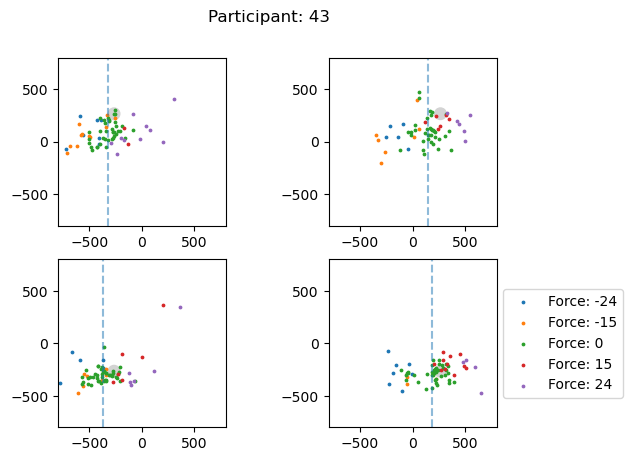

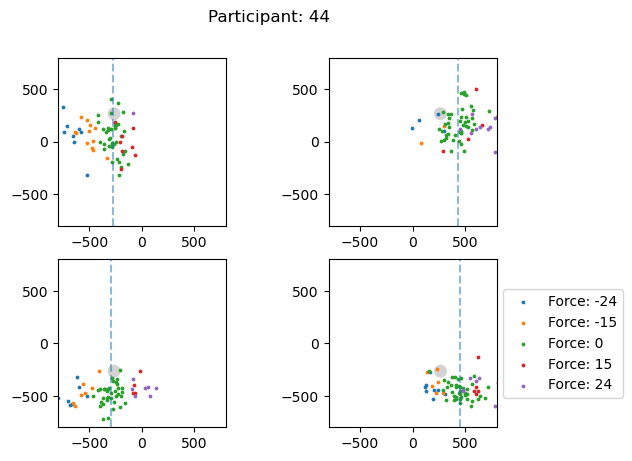

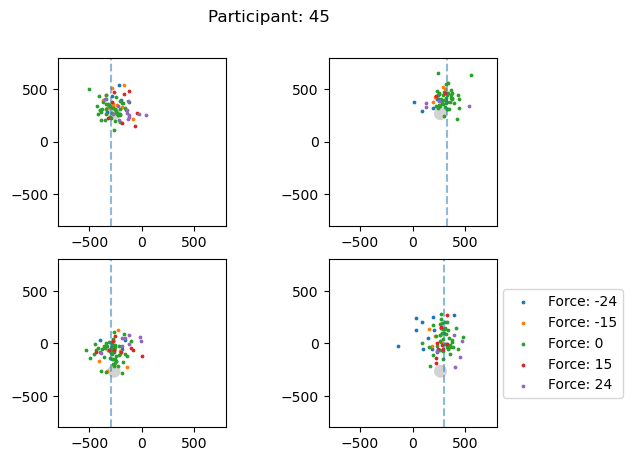

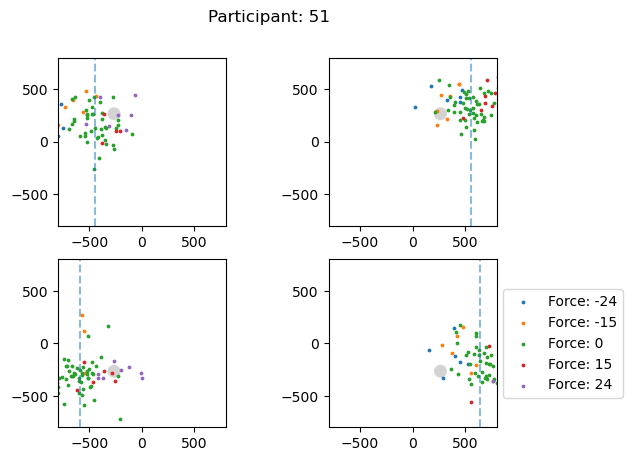

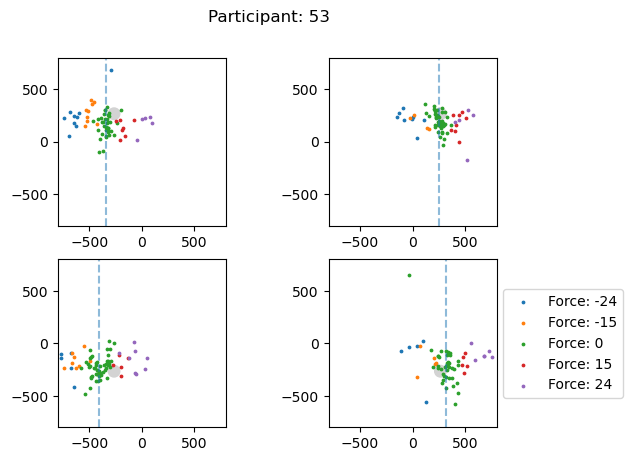

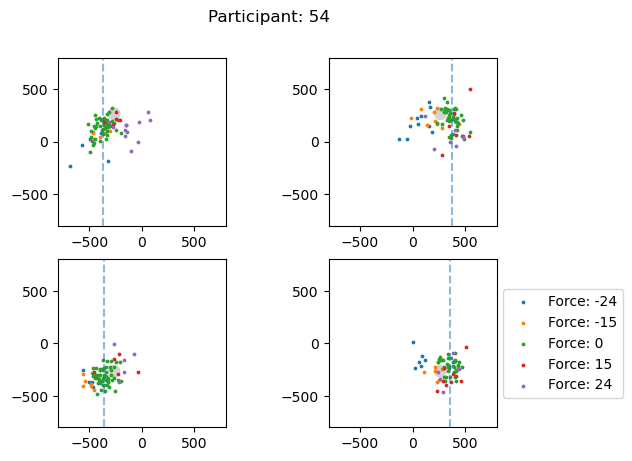

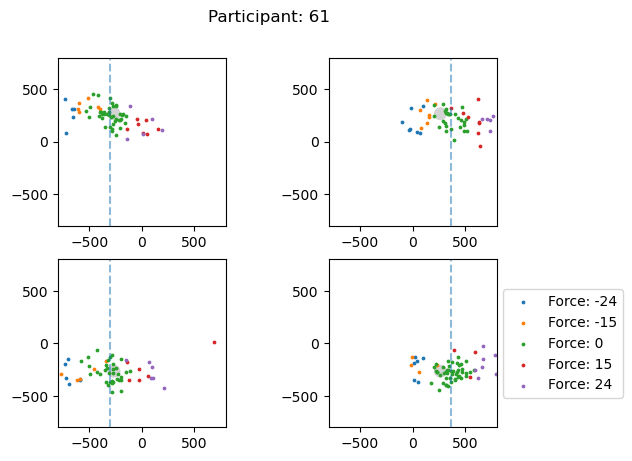

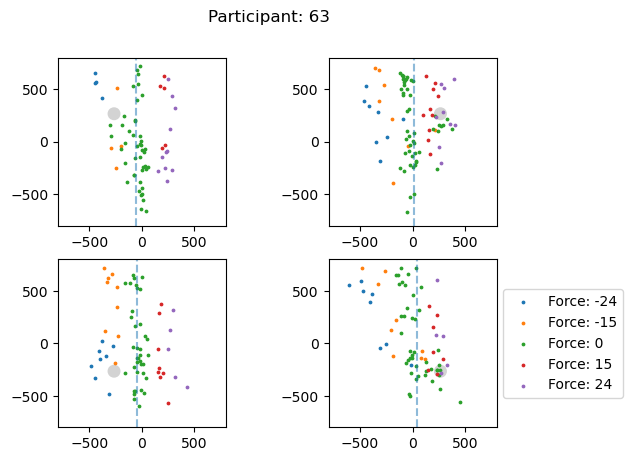

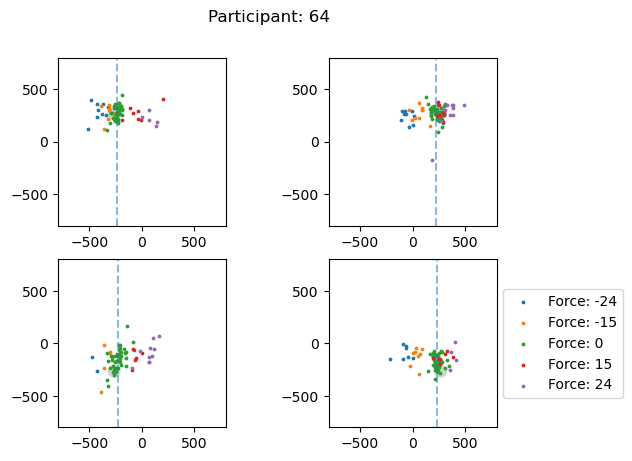

In [86]:
# 2.4.2
# figs
target_poss = ['[-266, 266]', '[266, 266]', '[-266, -266]', '[266, -266]']
idxs = [(0,0), (0,1), (1,0), (1,1)]

for p_id, trials in zip(p_ids, main_trials):
    fig, ax = plt.subplots(2,2)
    trials['burst_offset'] = trials['last_x_v'] - trials['last_x_real']
    trials['v_pr_x'] = trials['pr_mouse_pos_x'] + trials['burst_offset']
    for idx, t in zip(idxs, target_poss):
        data = trials[trials["pr_target"] == t].sort_values("trial_burst_force") 
        cc = plt.Circle(ast.literal_eval(t), 55, color='lightgray') 
        ax[idx[0]][idx[1]].set(xlim=(-800,800), ylim=(-800,800), aspect=1)
        ax[idx[0]][idx[1]].add_artist(cc)
        for f in data["trial_burst_force"].unique():
            x = data[data["trial_burst_force"] == f]["v_pr_x"]
            y = data[data["trial_burst_force"] == f]["pr_mouse_pos_y"]
            ax[idx[0]][idx[1]].scatter(x, y, s=3, label=f"Force: {f}")
            if f == 0:
                ax[idx[0]][idx[1]].axvline(x.mean(), alpha=0.5, ls="--")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    fig.suptitle(f"Participant: {p_id}")
    plt.show()